In [75]:
import sys
sys.path.append("../")

import torch
import numpy as np
import torch_geometric as pyg
from torch_geometric.utils import stochastic_blockmodel_graph, to_dense_adj, erdos_renyi_graph
from models.RDPG_GD import GRDPG_GD_Armijo
# from models.GRDPG_GD_Unroll_unshared_normalized import GD_Unroll
# from models.bigbird_attention import big_bird_attention
from models.early_stopper import EarlyStopper
from graspologic.embed import AdjacencySpectralEmbed 
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import pickle
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

# GCN Block

In [2]:
from torch_geometric.nn.conv import MessagePassing
import torch.nn as nn

class GCNLayer(MessagePassing):
    def __init__(self, c_in: int, c_out: int) -> None:
        super().__init__()
        self.lin1 = nn.Linear(c_in, c_out, bias=False)
        self.Q = nn.Parameter(torch.Tensor(1, c_out))
        
    def forward(self, input, edge_index):
        x_1 = self.propagate(edge_index, x=input)
        x_1 = input + self.lin1.forward(x_1)@torch.diag(self.Q[0])

        return x_1


## Test GCN Block

In [3]:
X = torch.arange(8, dtype=torch.float32).view(4, 2)
A = torch.Tensor([[1, 1, 0, 0], [1, 1, 1, 1], [0, 1, 1, 1], [0, 1, 1, 1]])
edge_index = A.nonzero().t().contiguous()

print("Señal de entrada X:\n", X)
print("\nMatriz de adyacencia:\n", A)
print("\nMatriz de adyacencia en formato edge index:\n", edge_index)

Señal de entrada X:
 tensor([[0., 1.],
        [2., 3.],
        [4., 5.],
        [6., 7.]])

Matriz de adyacencia:
 tensor([[1., 1., 0., 0.],
        [1., 1., 1., 1.],
        [0., 1., 1., 1.],
        [0., 1., 1., 1.]])

Matriz de adyacencia en formato edge index:
 tensor([[0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3],
        [0, 1, 0, 1, 2, 3, 1, 2, 3, 1, 2, 3]])


In [4]:
gcn = GCNLayer(c_in=2, c_out=2)

gcn.lin1.weight.data = torch.Tensor([[1.0, 1.0], [1.0, 1.0]])
gcn.Q.data = torch.Tensor([[1.0, -1.0]])

with torch.no_grad():
  Y = gcn(X, edge_index)

print("Señal de salida Y:\n", Y)

Señal de salida Y:
 tensor([[  6.,  -5.],
        [ 30., -25.],
        [ 31., -22.],
        [ 33., -20.]])


In [5]:
## Calculo manual
W1 = torch.Tensor([[1.0, 1.0], [1.0, 1.0]])
Q = torch.Tensor([[1.0, -1.0]])

Y_2 = X

Y_2= X + A@X@W1@torch.diag(Q[0])
print("Señal de salida Y:\n", Y_2)

Señal de salida Y:
 tensor([[  6.,  -5.],
        [ 30., -25.],
        [ 31., -22.],
        [ 33., -20.]])


# Transformer Block

In [6]:
import torch
import torch_geometric as pyg
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
from torch_geometric.utils import to_dense_adj
from torch_geometric.nn.conv import MessagePassing

class Transformer_Block(MessagePassing):
    def __init__(self, c_in, c_out):
        super().__init__()

        self.lin2 = nn.Linear(c_in, c_out, bias=False) ## value
        self.Q = nn.Parameter(torch.Tensor(1, c_out))

    def forward(self, input, edge_index, use_softmax=False, return_attn_matrix=False):

        ## Linear pass
        x2 = self.lin2(input)
        _x3 = input@torch.diag(self.Q[0])
        _x4 = input

        ## Get indexes with edges
        x3 = torch.index_select(_x3, 0, edge_index[0])
        x4 = torch.index_select(_x4, 0, edge_index[1])

        ## Calculate attention weights
        attn_weights = torch.einsum("hc,hc->h", x3, x4)
        attn_weights = attn_weights.reshape(-1)
        adj_matrix = to_dense_adj(edge_index)
        attn_matrix = to_dense_adj(edge_index, edge_attr=attn_weights).squeeze(0)

        ## Calculate final output
        x_2 = torch.einsum("ij,ih->jh", attn_matrix, x2)@torch.diag(self.Q[0])

        return x_2

## Test Transformer Block

In [7]:
gat = Transformer_Block(c_in=2, c_out=2)

gat.lin2.weight.data = torch.Tensor([[2.0, 1.0], [1.0, 2.0]])
gat.Q.data = torch.Tensor([[1.0, -1.0]])

edge_index_2 = torch.ones([4,4],).nonzero().t().contiguous()

with torch.no_grad():
  Y = gat(X, edge_index_2)

print("Señal de salida Y:\n", Y)

Señal de salida Y:
 tensor([[-220.,  236.],
        [-300.,  324.],
        [-380.,  412.],
        [-460.,  500.]])


In [8]:
## Calculo manual
W2 = torch.Tensor([[2.0, 1.0], [1.0, 2.0]])
Q = torch.Tensor([[1.0, -1.0]])

Y_2 = X@torch.diag(Q[0])@X.T@X@W2@torch.diag(Q[0])

print("Señal de salida Y:\n", Y_2)

Señal de salida Y:
 tensor([[-220.,  236.],
        [-300.,  324.],
        [-380.,  412.],
        [-460.,  500.]])


# GD Block

In [9]:
import torch.nn as nn
from torch_geometric.nn.conv import MessagePassing

class GD_Block(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.lin1 = nn.Linear(in_channels, out_channels, bias=False)
        self.lin2 = nn.Linear(in_channels, out_channels, bias=False)
        self.Q = nn.Parameter(torch.Tensor(1, out_channels))

    def forward(self, input, edge_index, edge_index_2): 
        
        ## GCN Layer
        x_1 = self.propagate(edge_index, x=input)
        x_1 = input + self.lin1.forward(x_1)@torch.diag(self.Q[0])


        ## GAT Layer
        x2 = self.lin2(input)
        _x3 = input@torch.diag(self.Q[0])
        _x4 = input

        ## Get indexes with edges
        x3 = torch.index_select(_x3, 0, edge_index_2[0])
        x4 = torch.index_select(_x4, 0, edge_index_2[1])

        ## Calculate attention weights
        attn_weights = torch.einsum("hc,hc->h", x3, x4)
        attn_weights = attn_weights.reshape(-1)
        adj_matrix = to_dense_adj(edge_index_2)
        attn_matrix = to_dense_adj(edge_index_2, edge_attr=attn_weights).squeeze(0)

        ## Calculate final output
        x_2 = torch.einsum("ij,ih->jh", attn_matrix, x2)@torch.diag(self.Q[0])

        return x_1 - x_2

## Test GD Block

In [10]:
gd = GD_Block(in_channels=2, out_channels=2)

gd.lin1.weight.data = torch.Tensor([[1.0, 1.0], [1.0, 1.0]])
gd.lin2.weight.data = torch.Tensor([[2.0, 1.0], [1.0, 2.0]])
gd.Q.data = torch.Tensor([[1.0, -1.0]])
edge_index_2 = torch.ones([4,4],).nonzero().t().contiguous()

with torch.no_grad():
  Y = gd(X, edge_index, edge_index_2)

print("Señal de salida Y:\n", Y)

Señal de salida Y:
 tensor([[ 226., -241.],
        [ 330., -349.],
        [ 411., -434.],
        [ 493., -520.]])


In [11]:
## Calculo manual
W1 = torch.Tensor([[1.0, 1.0], [1.0, 1.0]])
W2 = torch.Tensor([[2.0, 1.0], [1.0, 2.0]])
Q = torch.Tensor([[1.0, -1.0]])

Y_2 = X + A@X@W1@torch.diag(Q[0]) - X@torch.diag(Q[0])@X.T@X@W2@torch.diag(Q[0])

print("Señal de salida Y:\n", Y_2)

Señal de salida Y:
 tensor([[ 226., -241.],
        [ 330., -349.],
        [ 411., -434.],
        [ 493., -520.]])


# G-LASE

In [64]:
import torch.nn as nn
from torch_geometric.nn import Sequential

class gLASE(nn.Module):
    def __init__(self, in_channels, out_channels, gd_steps):
        super().__init__()

        self.gd_steps = gd_steps
        layers = []

        for _ in range(gd_steps):
            layers.append((GD_Block(in_channels, out_channels), 'x, edge_index, edge_index_2 -> x'))
        self.gd = Sequential('x, edge_index, edge_index_2', [layer for layer in layers])

    def forward(self, input, edge_index, edge_index_2): 
        x = input
        for step in range(self.gd_steps):
            self.gd[step].Q.data = self.gd[0].Q.data
        x = self.gd(x, edge_index, edge_index_2)
                
        return x


## Test G-LASE

In [38]:
gd_steps =  5
glase = gLASE(in_channels=2, out_channels=2, gd_steps = 5)

for step in range(gd_steps):
  glase.gd[step].lin1.weight.data = torch.Tensor([[1.0, 1.0], [1.0, 1.0]])
  glase.gd[step].lin2.weight.data = torch.Tensor([[2.0, 1.0], [1.0, 2.0]])*0.00001
  glase.gd[step].Q.data = torch.Tensor([[1.0, -1.0]])

with torch.no_grad():
  Y = glase(X, edge_index, edge_index_2)

print("Señal de salida Y:\n", Y)

Señal de salida Y:
 tensor([[  18.2241,  -18.4396],
        [ 100.1607, -101.1980],
        [  97.3414,  -97.4013],
        [  97.6033,  -96.7617]])


In [39]:
## Calculo manual

W1 = torch.Tensor([[1.0, 1.0], [1.0, 1.0]])
W2 = torch.Tensor([[2.0, 1.0], [1.0, 2.0]])*0.00001
Q = torch.Tensor([[1.0, -1.0]])

Y_2 = X
for step in range(gd_steps):
    Y_2 = Y_2 + A@Y_2@W1@torch.diag(Q[0]) - Y_2@torch.diag(Q[0])@Y_2.T@Y_2@W2@torch.diag(Q[0])

print("Señal de salida Y:\n", Y_2)

Señal de salida Y:
 tensor([[  18.2241,  -18.4396],
        [ 100.1607, -101.1980],
        [  97.3414,  -97.4013],
        [  97.6033,  -96.7617]])


# Train G-LASE

torch.return_types.linalg_eig(
eigenvalues=tensor([ 0.9000+0.j, -0.9000+0.j]),
eigenvectors=tensor([[ 0.7071+0.j, -0.7071+0.j],
        [ 0.7071+0.j,  0.7071+0.j]]))
tensor(20.5406)


<Axes: >

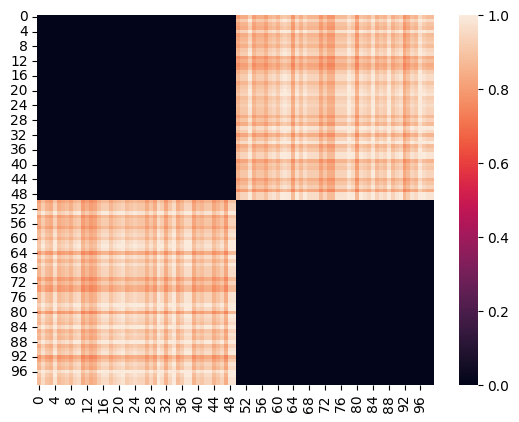

In [128]:
num_nodes = 100
d = 2
device = 'cpu'
epochs = 30000
lr=1e-3
gd_steps = 5
MODEL_FILE='../saved_models/glase_unshared_d3_normalized__full.pt'
TRAIN_DATA_FILE='./data/sbm3_train.pkl'
VAL_DATA_FILE='./data/sbm3_val.pkl'

n = [50, 50]
p = [
     [0.0, 0.9],
     [0.9, 0.0]
]

print(torch.linalg.eig(torch.Tensor(p)))

edge_index = stochastic_blockmodel_graph(n, p).to(device)
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)

x = torch.rand((num_nodes, d)).to(device)

q = torch.cat((torch.ones(d // 2), -torch.ones(d // 2)))
Q_ = torch.diag(q)
x_gd, cost, k = GRDPG_GD_Armijo(x, edge_index, Q_, mask, tol=1e-3, max_iter=10000)
loss = torch.norm((x_gd@Q_@x_gd.T - to_dense_adj(edge_index).squeeze(0)))
print(loss)
sns.heatmap(x_gd@Q_@x_gd.T, vmin=0.0, vmax=1.0, cbar=True)


## With given Ipq

In [62]:
model = gLASE(d, d, gd_steps)
model.to(device)

for step in range(gd_steps):
    
    model.gd[step].lin1.weight.data = torch.nn.init.xavier_uniform_(model.gd[step].lin1.weight)*lr
    model.gd[step].lin2.weight.data = torch.nn.init.xavier_uniform_(model.gd[step].lin2.weight)*lr
    model.gd[step].Q.data = torch.Tensor([[1,-1]]).to(device)
    model.gd[step].Q.requires_grad = False
    

Train Loss: 74.77901458740234
Train Loss: 49.65461349487305
Train Loss: 49.64030456542969
Train Loss: 49.6351318359375
Train Loss: 49.63240432739258
Train Loss: 49.63020324707031
Train Loss: 49.62926483154297
Train Loss: 49.62834167480469
Train Loss: 49.627227783203125
Train Loss: 49.62580490112305
Train Loss: 49.62355041503906
Train Loss: 49.606971740722656
Train Loss: 50.4286994934082
Train Loss: 49.798282623291016
Train Loss: 49.5753173828125
Train Loss: 49.20377731323242
Train Loss: 33.55459976196289
Train Loss: 22.573732376098633
Train Loss: 21.84130096435547
Train Loss: 21.41877555847168
Train Loss: 21.213205337524414
Train Loss: 21.209672927856445
Train Loss: 21.206541061401367
Train Loss: 21.203819274902344
Train Loss: 21.210002899169922
Train Loss: 21.192956924438477
Train Loss: 21.188703536987305
Train Loss: 21.18589210510254
Train Loss: 21.181428909301758
Train Loss: 21.177330017089844


<Axes: title={'center': 'G-LASE unshared weights (5 layers)'}>

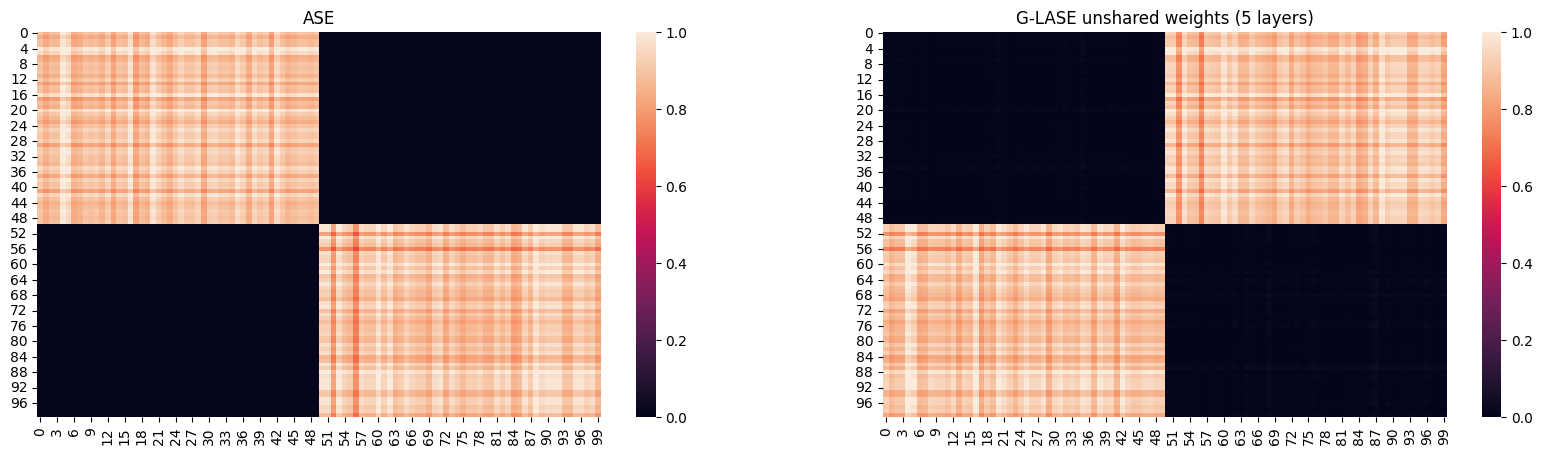

In [63]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


for epoch in range(epochs):
    # Train
    model.train()
    optimizer.zero_grad()
    out = model(x, edge_index, edge_index_2)
    I_pq = torch.diag(model.gd[0].Q[0])
    loss = torch.norm((out@I_pq@out.T - to_dense_adj(edge_index).squeeze(0)))
    loss.backward() 
    optimizer.step() 

    if epoch % 1000 == 0:
        print(f'Train Loss: {loss}')





x_glase = out.detach()
x_glase = x_glase.to('cpu')
Q = I_pq.detach().to('cpu')

fig, axes = plt.subplots(1, 2, figsize =(20,5))
axes[0].set_title('ASE')
sns.heatmap(Xhats@Xhats.T, ax=axes[0], vmin=0.0, vmax=1.0, cbar=True)
axes[1].set_title(f'G-LASE unshared weights ({gd_steps} layers)')
sns.heatmap(x_glase@Q@x_glase.T, ax=axes[1], vmin=0.0, vmax=1.0, cbar=True)

## No activation 

In [66]:
model = gLASE(d, d, gd_steps)
model.to(device)

for step in range(gd_steps):
    
    model.gd[step].lin1.weight.data = torch.nn.init.xavier_uniform_(model.gd[step].lin1.weight)*lr
    model.gd[step].lin2.weight.data = torch.nn.init.xavier_uniform_(model.gd[step].lin2.weight)*lr
    model.gd[step].Q.data = torch.ones([1,d]).to(device)
    

Train Loss: 54.93793487548828
Train Loss: 50.277732849121094
Train Loss: 50.0955924987793
Train Loss: 50.02172088623047
Train Loss: 49.96613693237305
Train Loss: 49.915855407714844
Train Loss: 49.867427825927734
Train Loss: 49.820411682128906
Train Loss: 49.775604248046875
Train Loss: 49.733829498291016
Train Loss: 49.69520568847656
Train Loss: 49.65672302246094
Train Loss: 49.64836883544922
Train Loss: 49.6451530456543
Train Loss: 49.64366149902344
Train Loss: 49.641239166259766
Train Loss: 49.63743209838867
Train Loss: 49.63185119628906
Train Loss: 49.623374938964844
Train Loss: 49.63594055175781
Train Loss: 49.62604522705078
Train Loss: 49.625038146972656
Train Loss: 49.62393569946289
Train Loss: 49.62205123901367
Train Loss: 49.618927001953125
Train Loss: 49.61336135864258
Train Loss: 49.622398376464844
Train Loss: 49.61547088623047
Train Loss: 49.614444732666016
Train Loss: 49.6133918762207


<Axes: title={'center': 'G-LASE unshared weights (5 layers)'}>

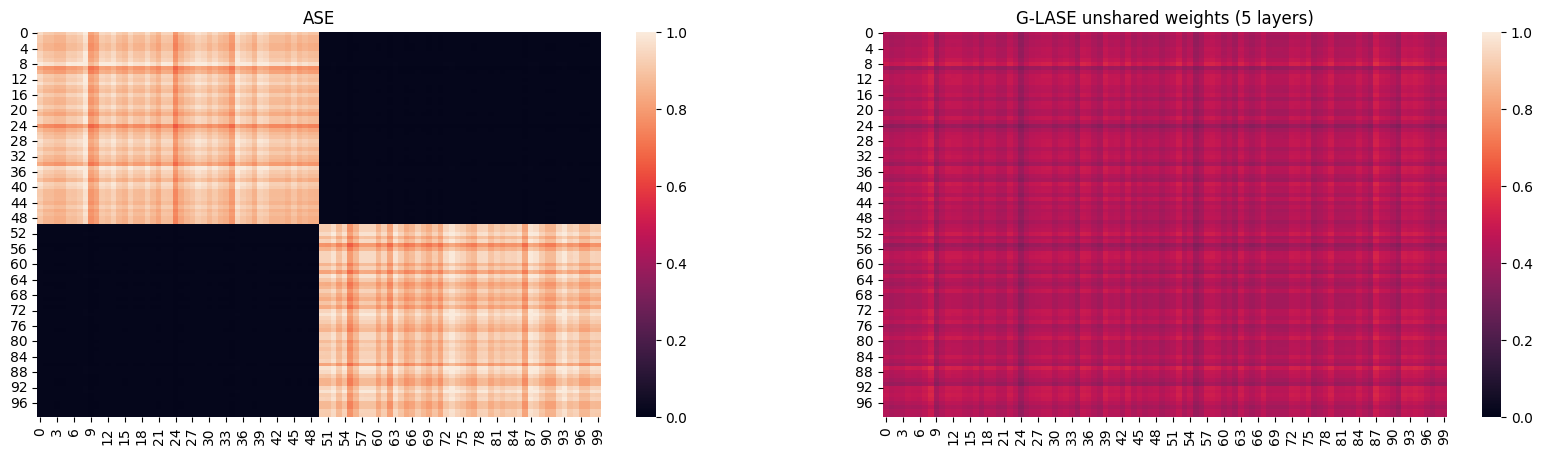

In [67]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


for epoch in range(epochs):
    # Train
    model.train()
    optimizer.zero_grad()
    out = model(x, edge_index, edge_index_2)
    I_pq = torch.diag(model.gd[0].Q[0])
    loss = torch.norm((out@I_pq@out.T - to_dense_adj(edge_index).squeeze(0)))
    loss.backward() 
    optimizer.step() 

    if epoch % 1000 == 0:
        print(f'Train Loss: {loss}')


x_glase = out.detach()
x_glase = x_glase.to('cpu')
Q = I_pq.detach().to('cpu')

fig, axes = plt.subplots(1, 2, figsize =(20,5))
axes[0].set_title('ASE')
sns.heatmap(Xhats@Xhats.T, ax=axes[0], vmin=0.0, vmax=1.0, cbar=True)
axes[1].set_title(f'G-LASE unshared weights ({gd_steps} layers)')
sns.heatmap(x_glase@Q@x_glase.T, ax=axes[1], vmin=0.0, vmax=1.0, cbar=True)

In [69]:
for step in range(gd_steps):
    print(model.gd[step].Q.data)

tensor([[0.0151, 0.0171]])
tensor([[0.0152, 0.0171]])
tensor([[0.0152, 0.0171]])
tensor([[0.0152, 0.0171]])
tensor([[0.0151, 0.0171]])


## With tanh activation

In [86]:
import torch.nn as nn
from torch_geometric.nn import Sequential

class gLASE(nn.Module):
    def __init__(self, in_channels, out_channels, gd_steps):
        super().__init__()

        self.gd_steps = gd_steps
        self.activation = nn.Tanh()
        layers = []

        for _ in range(gd_steps):
            layers.append((GD_Block(in_channels, out_channels), 'x, edge_index, edge_index_2 -> x'))
        self.gd = Sequential('x, edge_index, edge_index_2', [layer for layer in layers])

    def forward(self, input, edge_index, edge_index_2): 
        x = input
        for step in range(self.gd_steps):
            self.gd[step].Q.data = self.activation(self.gd[0].Q.data)
        x = self.gd(x, edge_index, edge_index_2)
                
        return x


In [88]:
model = gLASE(d, d, gd_steps)
model.to(device)

for step in range(gd_steps):
    
    model.gd[step].lin1.weight.data = torch.nn.init.xavier_uniform_(model.gd[step].lin1.weight)*lr
    model.gd[step].lin2.weight.data = torch.nn.init.xavier_uniform_(model.gd[step].lin2.weight)*lr
    model.gd[step].Q.data = torch.rand([1,d]).to(device)#torch.ones([1,d]).to(device)
    

In [89]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


for epoch in range(epochs):
    # Train
    model.train()
    optimizer.zero_grad()
    out = model(x, edge_index, edge_index_2)
    I_pq = torch.diag(model.gd[0].Q[0])
    loss = torch.norm((out@I_pq@out.T - to_dense_adj(edge_index).squeeze(0)))
    loss.backward() 
    optimizer.step() 

    if epoch % 2000 == 0:
        print(f'Train Loss: {loss}')




Train Loss: 55.334774017333984
Train Loss: 49.662410736083984
Train Loss: 49.66036605834961
Train Loss: 49.6600227355957
Train Loss: 49.65977478027344
Train Loss: 49.6596794128418
Train Loss: 49.660377502441406
Train Loss: 49.669883728027344
Train Loss: 49.664451599121094
Train Loss: 49.661048889160156
Train Loss: 49.659175872802734
Train Loss: 49.65922927856445
Train Loss: 49.65982437133789
Train Loss: 49.681392669677734
Train Loss: 49.6594352722168


<Axes: title={'center': 'G-LASE unshared weights (5 layers)'}>

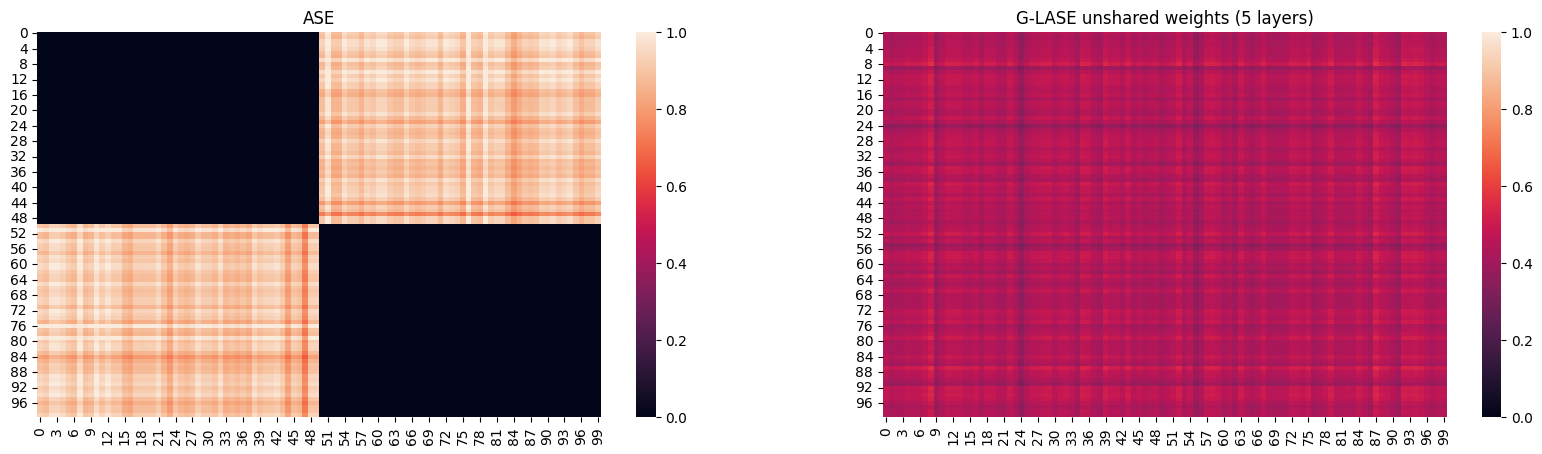

In [82]:
x_glase = out.detach()
x_glase = x_glase.to('cpu')
Q = I_pq.detach().to('cpu')

fig, axes = plt.subplots(1, 2, figsize =(20,5))
axes[0].set_title('ASE')
sns.heatmap(x_gd@Q_@x_gd.T, ax=axes[0], vmin=0.0, vmax=1.0, cbar=True)
axes[1].set_title(f'G-LASE unshared weights ({gd_steps} layers)')
sns.heatmap(x_glase@Q@x_glase.T, ax=axes[1], vmin=0.0, vmax=1.0, cbar=True)

In [90]:
for step in range(gd_steps):
    print(model.gd[step].Q.data)

tensor([[0.0294, 0.0154]])
tensor([[0.0294, 0.0154]])
tensor([[0.0294, 0.0154]])
tensor([[0.0294, 0.0154]])
tensor([[0.0294, 0.0154]])


# Adding regularization l1 penalty

In [140]:
import torch.nn as nn
from torch_geometric.nn import Sequential

class gLASE(nn.Module):
    def __init__(self, in_channels, out_channels, gd_steps):
        super().__init__()

        self.gd_steps = gd_steps
        self.activation = nn.Tanh()
        layers = []

        for _ in range(gd_steps):
            layers.append((GD_Block(in_channels, out_channels), 'x, edge_index, edge_index_2 -> x'))
        self.gd = Sequential('x, edge_index, edge_index_2', [layer for layer in layers])

    def forward(self, input, edge_index, edge_index_2): 
        x = input
        #for step in range(self.gd_steps):
            #self.gd[step].Q.data = self.gd[0].Q.data
        x = self.gd(x, edge_index, edge_index_2)
                
        return x


In [141]:
model = gLASE(d, d, gd_steps)
model.to(device)

for step in range(gd_steps):
    
    model.gd[step].lin1.weight.data = lr*torch.eye(d).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin1.weight)*lr
    # model.gd[step].lin1.weight.requires_grad = False
    model.gd[step].lin2.weight.data = lr*torch.eye(d).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin2.weight)*lr
    # model.gd[step].lin2.weight.requires_grad = False
    model.gd[step].Q.data = (torch.rand([1,d])-0.5).to(device)#torch.ones([1,d]).to(device)

In [142]:
# Define a custom loss function with L1 regularization
class DiscreteRegularizationLoss(nn.Module):
    def __init__(self, model, lambda_reg):
        super(DiscreteRegularizationLoss, self).__init__()
        self.model = model
        self.lambda_reg = lambda_reg

    def forward(self):
        l1_loss = torch.sum(torch.abs(self.model.gd[0].Q[0] - 1.0)) + torch.sum(torch.abs(self.model.gd[0].Q[0] + 1.0))
        return l1_loss * self.lambda_reg

# Define the regularization strength (lambda)
lambda_reg = 0.5

# Custom loss function with L1 regularization
reg_loss_fn = DiscreteRegularizationLoss(model, lambda_reg)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    # Train
    model.train()
    optimizer.zero_grad()
    out = model(x, edge_index, edge_index_2)
    I_pq = torch.diag(model.gd[0].Q[0])
    loss = torch.norm((out@I_pq@out.T - to_dense_adj(edge_index).squeeze(0))) + reg_loss_fn()
    loss.backward() 
    optimizer.step() 

    if epoch % 2000 == 0:
        print(f'Train Loss: {loss}')
        print(model.gd[0].Q[0])


Train Loss: 75.67623901367188
tensor([-0.3778,  0.0359], grad_fn=<SelectBackward0>)
Train Loss: 22.54802703857422
tensor([-0.4138,  0.0747], grad_fn=<SelectBackward0>)
Train Loss: 22.5428524017334
tensor([-0.4169,  0.0774], grad_fn=<SelectBackward0>)
Train Loss: 22.541332244873047
tensor([-0.4177,  0.0804], grad_fn=<SelectBackward0>)
Train Loss: 22.54330062866211
tensor([-0.4160,  0.0816], grad_fn=<SelectBackward0>)
Train Loss: 22.550254821777344
tensor([-0.4138,  0.0829], grad_fn=<SelectBackward0>)
Train Loss: 22.54228401184082
tensor([-0.4117,  0.0843], grad_fn=<SelectBackward0>)
Train Loss: 22.541259765625
tensor([-0.4097,  0.0858], grad_fn=<SelectBackward0>)
Train Loss: 22.54538917541504
tensor([-0.4079,  0.0874], grad_fn=<SelectBackward0>)
Train Loss: 22.543289184570312
tensor([-0.4064,  0.0888], grad_fn=<SelectBackward0>)
Train Loss: 22.547094345092773
tensor([-0.4050,  0.0901], grad_fn=<SelectBackward0>)
Train Loss: 22.54159927368164
tensor([-0.4037,  0.0913], grad_fn=<SelectBac

<Axes: title={'center': 'G-LASE unshared weights (5 layers)'}>

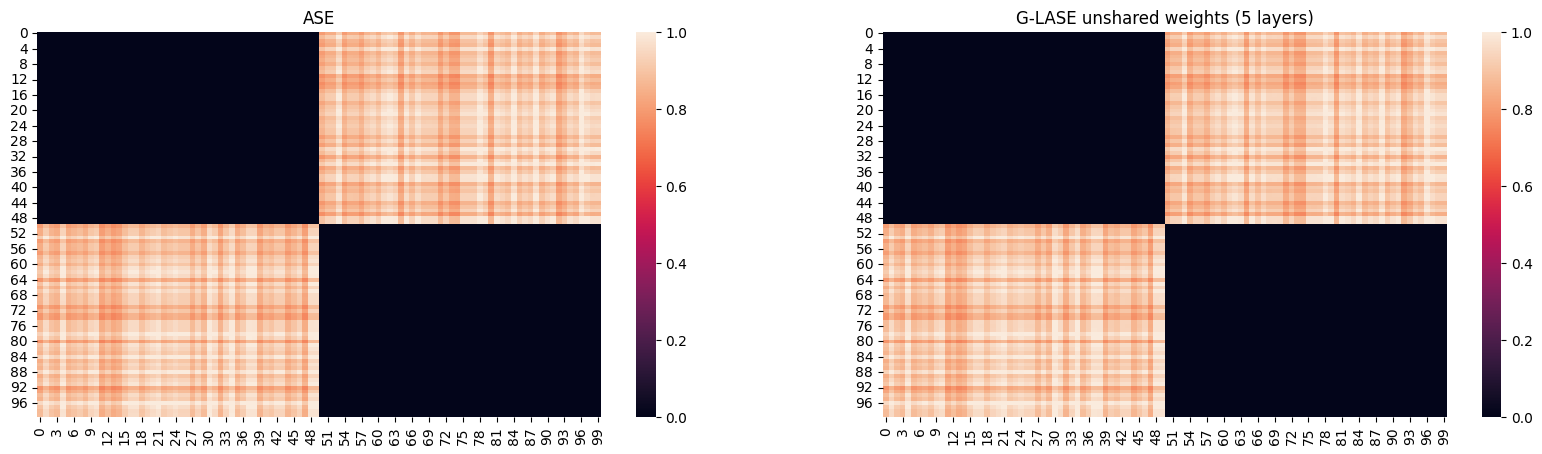

In [143]:
x_glase = out.detach()
x_glase = x_glase.to('cpu')
Q = I_pq.detach().to('cpu')

fig, axes = plt.subplots(1, 2, figsize =(20,5))
axes[0].set_title('ASE')
sns.heatmap(x_gd@Q_@x_gd.T, ax=axes[0], vmin=0.0, vmax=1.0, cbar=True)
axes[1].set_title(f'G-LASE unshared weights ({gd_steps} layers)')
sns.heatmap(x_glase@Q@x_glase.T, ax=axes[1], vmin=0.0, vmax=1.0, cbar=True)

In [144]:
model.gd[0].Q[0]

tensor([-0.3976,  0.0954], grad_fn=<SelectBackward0>)

## Training by steps

In [135]:
model = gLASE(d, d, gd_steps)
model.to(device)

for step in range(gd_steps):
    
    #model.gd[step].lin1.weight.data = lr*torch.eye(d).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin1.weight)*lr
    model.gd[step].lin1.weight.requires_grad = False
    #model.gd[step].lin2.weight.data = lr*torch.eye(d).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin2.weight)*lr
    model.gd[step].lin2.weight.requires_grad = False
    #model.gd[step].Q.data = (torch.rand([1,d])-0.5).to(device)#torch.ones([1,d]).to(device)
    model.gd[step].Q.requires_grad = True

In [136]:
# Define a custom loss function with L1 regularization
class DiscreteRegularizationLoss(nn.Module):
    def __init__(self, model, lambda_reg):
        super(DiscreteRegularizationLoss, self).__init__()
        self.model = model
        self.lambda_reg = lambda_reg

    def forward(self):
        l1_loss = torch.sum(torch.abs(self.model.gd[0].Q[0] - 1.0)) + torch.sum(torch.abs(self.model.gd[0].Q[0] + 1.0))
        return l1_loss * self.lambda_reg

# Define the regularization strength (lambda)
lambda_reg = 0.5

# Custom loss function with L1 regularization
reg_loss_fn = DiscreteRegularizationLoss(model, lambda_reg)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    # Train
    model.train()
    optimizer.zero_grad()
    out = model(x, edge_index, edge_index_2)
    I_pq = torch.diag(model.gd[0].Q[0])
    loss = torch.norm((out@I_pq@out.T - to_dense_adj(edge_index).squeeze(0))) + reg_loss_fn()
    loss.backward() 
    optimizer.step() 

    if epoch % 2000 == 0:
        print(f'Train Loss: {loss}')
        print(model.gd[0].Q[0])


Train Loss: 69.15653228759766
tensor([0.0010, 0.0010], grad_fn=<SelectBackward0>)
Train Loss: 68.87781524658203
tensor([0.0183, 0.0457], grad_fn=<SelectBackward0>)
Train Loss: 68.91607666015625
tensor([0.0190, 0.0498], grad_fn=<SelectBackward0>)
Train Loss: 68.91950988769531
tensor([0.0209, 0.0496], grad_fn=<SelectBackward0>)
Train Loss: 68.94648742675781
tensor([0.0275, 0.0438], grad_fn=<SelectBackward0>)
Train Loss: 68.1473159790039
tensor([-0.0911,  0.0308], grad_fn=<SelectBackward0>)
Train Loss: 67.64022064208984
tensor([-0.0923,  0.0334], grad_fn=<SelectBackward0>)
Train Loss: 67.21626281738281
tensor([-0.0967,  0.0343], grad_fn=<SelectBackward0>)
Train Loss: 50.881656646728516
tensor([-0.1319,  0.0406], grad_fn=<SelectBackward0>)
Train Loss: 50.880889892578125
tensor([-0.1319,  0.0406], grad_fn=<SelectBackward0>)
Train Loss: 50.875518798828125
tensor([-0.1319,  0.0406], grad_fn=<SelectBackward0>)
Train Loss: 50.85768508911133
tensor([-0.1320,  0.0408], grad_fn=<SelectBackward0>)


<Axes: title={'center': 'G-LASE unshared weights (5 layers)'}>

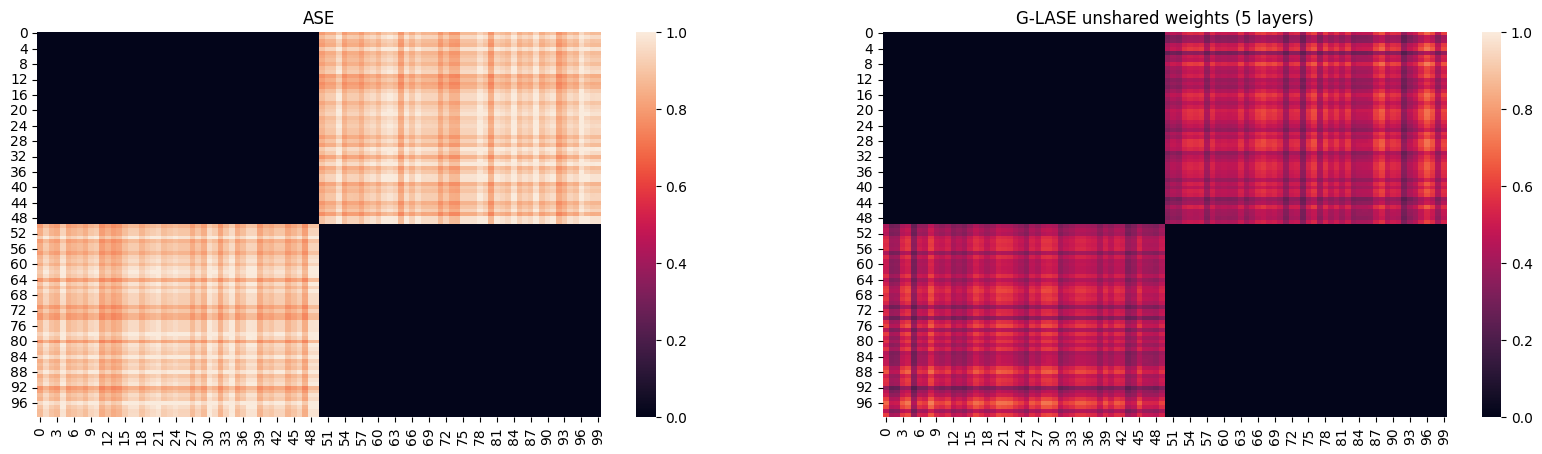

In [137]:
x_glase = out.detach()
x_glase = x_glase.to('cpu')
Q = I_pq.detach().to('cpu')

fig, axes = plt.subplots(1, 2, figsize =(20,5))
axes[0].set_title('ASE')
sns.heatmap(x_gd@Q_@x_gd.T, ax=axes[0], vmin=0.0, vmax=1.0, cbar=True)
axes[1].set_title(f'G-LASE unshared weights ({gd_steps} layers)')
sns.heatmap(x_glase@Q@x_glase.T, ax=axes[1], vmin=0.0, vmax=1.0, cbar=True)

In [138]:
model = gLASE(d, d, gd_steps)
model.to(device)

for step in range(gd_steps):
    
    #model.gd[step].lin1.weight.data = lr*torch.eye(d).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin1.weight)*lr
    model.gd[step].lin1.weight.requires_grad = True
    #model.gd[step].lin2.weight.data = lr*torch.eye(d).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin2.weight)*lr
    model.gd[step].lin2.weight.requires_grad = True
    #model.gd[step].Q.data = (torch.rand([1,d])-0.5).to(device)#torch.ones([1,d]).to(device)
    model.gd[step].Q.requires_grad = False

In [139]:
# Define a custom loss function with L1 regularization
class DiscreteRegularizationLoss(nn.Module):
    def __init__(self, model, lambda_reg):
        super(DiscreteRegularizationLoss, self).__init__()
        self.model = model
        self.lambda_reg = lambda_reg

    def forward(self):
        l1_loss = torch.sum(torch.abs(self.model.gd[0].Q[0] - 1.0)) + torch.sum(torch.abs(self.model.gd[0].Q[0] + 1.0))
        return l1_loss * self.lambda_reg

# Define the regularization strength (lambda)
lambda_reg = 0.5

# Custom loss function with L1 regularization
reg_loss_fn = DiscreteRegularizationLoss(model, lambda_reg)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    # Train
    model.train()
    optimizer.zero_grad()
    out = model(x, edge_index, edge_index_2)
    I_pq = torch.diag(model.gd[0].Q[0])
    loss = torch.norm((out@I_pq@out.T - to_dense_adj(edge_index).squeeze(0))) #+ reg_loss_fn()
    loss.backward() 
    optimizer.step() 

    if epoch % 2000 == 0:
        print(f'Train Loss: {loss}')
        #print(model.gd[0].Q[0])


Train Loss: 67.15653228759766
Train Loss: 67.15653228759766
Train Loss: 67.15653228759766
Train Loss: 67.15653228759766
Train Loss: 67.15653228759766
Train Loss: 67.15653228759766


KeyboardInterrupt: 